In [41]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from langgraph.prebuilt import ToolNode
from typing_extensions import TypedDict
from langgraph.graph import add_messages
from langchain_core.tools import tool
from dotenv import load_dotenv
load_dotenv()
from langgraph.graph import StateGraph,END,START
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()



In [32]:


class State(TypedDict):
    messages: Annotated[list,add_messages]


In [56]:
@tool
def stock_price_tool(symbol: str) -> float:
    """
    this function takes stock symbol as input and returns stock price

    :param symbol: stock symbol
    :return: stock price

     """
    return {
        "AAP" : 45.0,
        "RIL" : 39.9,
        "MSFT" : 44.0,
        "AMZN" : 39.9
    }.get(symbol.upper(), 0)
tools = [stock_price_tool]
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)



In [57]:
def chatbot(state:State)->State:
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [58]:
builder = StateGraph(State)
builder.add_node("chatbot",chatbot)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"chatbot")
builder.add_conditional_edges("chatbot",tools_condition)
builder.add_edge("tools","chatbot")
builder.add_edge("chatbot",END)
#


graph = builder.compile(checkpointer=memory)



In [59]:
from IPython.display import display,Image

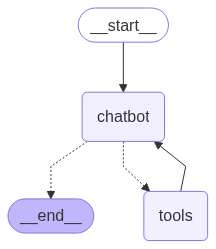

In [60]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
# config1 = {"configurable":{"thread id":"1"}}

In [62]:
config1 = { 'configurable': { 'thread_id': '1'} }

msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

OK. The current price of AMZN is $39.9 and MSFT is $44.
The total cost will be 20 * 39.9 + 15 * 44 = $1458


In [63]:
msg = "Using the current price tell me the total price of 10 RIL stocks and add it to previous total cost"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

The current price of RIL is $39.9.
The total cost of 10 RIL stocks is 10 * 39.9 = $399.
Adding it to the previous total cost, the new total cost is $1458 + $399 = $1857.


In [64]:
print(state["messages"])

[HumanMessage(content='I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?', additional_kwargs={}, response_metadata={}, id='9d89298d-2465-4e13-8f4d-f80a64ded77a'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'stock_price_tool', 'arguments': '{"symbol": "MSFT"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--dfb891a5-130a-4f0c-b011-4e993924f0cb-0', tool_calls=[{'name': 'stock_price_tool', 'args': {'symbol': 'AMZN'}, 'id': '0fbf3602-e6fc-4727-a1ca-3dd871abd02a', 'type': 'tool_call'}, {'name': 'stock_price_tool', 'args': {'symbol': 'MSFT'}, 'id': '86425947-5745-474b-9b93-6d0f7ac9af41', 'type': 'tool_call'}], usage_metadata={'input_tokens': 61, 'output_tokens': 16, 'total_tokens': 77, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='39.9', name='stock_price_tool', id='f8c7fbbd-1aad-42